# Generating Shakespeare character by character

This is a small example of a GPT that is trained on Shakespeare text. This notebook has major inspiration from https://github.com/karpathy/nanoGPT. It's great to get familiar and play around with GPT alwhile not necessarly having a cluster of 1000s of GPUs.

In [ ]:
import os 
import torch
import pickle
import matplotlib.pyplot as plt

from misc import get_batch
from model.gpt2 import GPT2
from trainer.gpt_trainer import GPTTrainer

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

We launch the `data/shakespeare_char/prepare.py` file in order to have our data setup.

In [2]:
! python data/shakespeare_char/prepare.py 

length of dataset in characters: 1,115,394
all the unique characters: 
 !$&',-.3:;?ABCDEFGHIJKLMNOPQRSTUVWXYZabcdefghijklmnopqrstuvwxyz
vocab size: 65
train has 1,003,854 tokens
val has 111,540 tokens


In this dataset we have 65 unique characters that form our vocabulary size, 1M tokens for training and 100k for validation.

In [3]:
data_dir = "data/shakespeare_char/"
meta_path = os.path.join(data_dir, 'meta.pkl')
vocab_size = None

if os.path.exists(meta_path):
    with open(meta_path, 'rb') as f:
        meta = pickle.load(f)
    vocab_size = meta['vocab_size']
    itos = meta['itos']
    stoi = meta['stoi']
    print(f"found vocab_size = {vocab_size} (inside {meta_path})")

found vocab_size = 65 (inside data/shakespeare_char/meta.pkl)


We then get some meta data and other convienences. For example, the GPT trained hereafter will have the task of predicting the next Shakesperian character given its context. Autoregressively, you can generate many characters that will eventually form words and sentences.

The function `encode` and `decode` will help to convert the produced GPT output into readable characters. We also provide an example of how a `str` is encoded for the model and how the model's output `array` of `int` are decoded to produce Shaspearian litterature.

In [4]:
encode = lambda s: torch.tensor([stoi[c] for c in s])
decode = lambda l: ''.join([itos[i] for i in l])

shakpeare_lines = "the king will"
x = encode(shakpeare_lines)
print("The text '{}' is encoded and fed to the GPT as {}".format(shakpeare_lines, x))
y = decode(x.tolist())
assert shakpeare_lines == y

The text 'the king will' is encoded and fed to the GPT as tensor([58, 46, 43,  1, 49, 47, 52, 45,  1, 61, 47, 50, 50])


We choose to use the same hyperparameters from https://github.com/karpathy/nanoGPT for a small example of CPU. 

In [5]:
block_size = 64
n_layer, n_head, n_embd, dropout = 4, 4, 128, 0.0

model = GPT2(vocab_size, block_size, n_embd, n_head, n_layer)
model = model.to(device)
print("GPT number of parameters:", sum(p.numel() for p in model.parameters()))

GPT number of parameters: 813889


We instantiate also our `GPTTrainer` code in `train.py`. 

In [6]:
trainer = GPTTrainer(model, lr=5e-4, checkpoint_path="metadata/shakespeare_char/")

We call the `train` method from our `trainer` that takes as input : 
- `get_batch`: a function that fetches batches of data
- `max_iters`: number of max iterations
- `batch_size`: batch size 
- `patience`: an argument that essentially spots the training if the validation loss hasn't improve in `#patience` optimization steps. 
- `save_every`: that saves the model weights and other things at `save_every` multiples of iteration step. 

In [7]:
partial_get_batch = lambda split, batch_size: get_batch(data_dir, split, batch_size, device, block_size)
trainer.train(partial_get_batch, max_iters=2000, batch_size=64, patience=2000, save_every=30)

Iter :1999/2000 Train Loss 1.525e+00 / Eval Loss 1.671e+00: 100%|██████████| 2000/2000 [05:12<00:00,  6.39it/s]


Lets see the loss curve from this training and also generate some text ! We also added a `temperature` and `top_k` hyperparameters to give a bit more flexibility to the generation. 

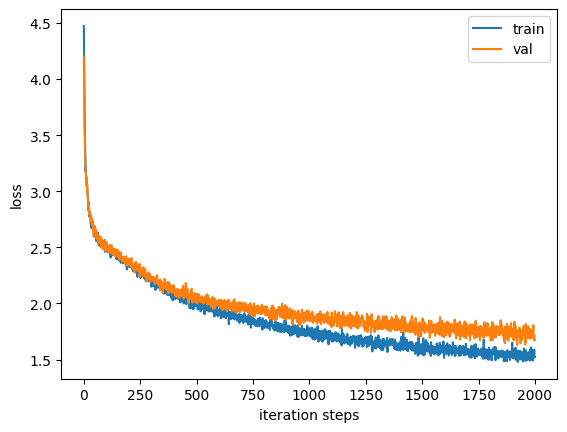

In [8]:
plt.plot(trainer.losses, label='train')
plt.plot(trainer.val_losses, label='val')
plt.xlabel('iteration steps')
plt.ylabel('loss')
plt.legend()

In [9]:
model.eval()
x = encode("the king will \n")
x = x.view(1, -1).to(device)
y = model.generate(x, 2*256, temperature=1.0, top_k=None)
print(decode(y[0].tolist()))

100%|██████████| 512/512 [00:03<00:00, 160.87it/s]

the king will 
Forse take of thy ffeel.

Figness
To you him amabough, by we well!
One are chrience on soon, the me! one my lord:
Gelloughoran!

MENENIUS:
Not queent, made, are sir; we as wate-bell.
Thou a lawfull you, let's, were is a not retended
Every forth on their deech orsed; dukisse
Mighters hastyiurs. Norties deept it off,
Fare in book now not: ene the minest walled or
Your had firly-cresect to mark belood,
They roun to our corted, it thee loater,
Do no carmers, Exirst, so you are to the one of in
Word methought to
